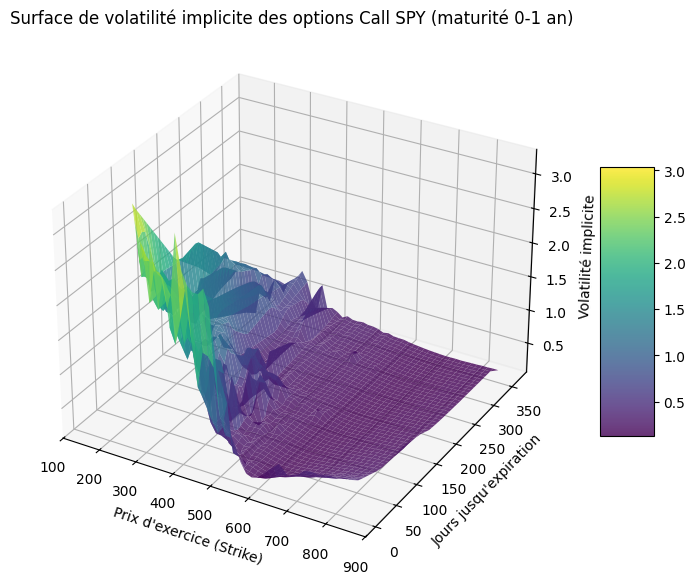

In [2]:

# Importation des bibliothèques nécessaires
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import datetime

# Fonction pour calculer la volatilité implicite d'une option call via Black-Scholes
def black_scholes_iv(S, K, T, r, market_price):
    def bs_call_price(vol):
        d1 = (np.log(S / K) + (r + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
        d2 = d1 - vol * np.sqrt(T)
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    try:
        iv = brentq(lambda vol: bs_call_price(vol) - market_price, 1e-6, 5)
    except ValueError:
        iv = np.nan
    return iv

# Extraction des données d'options pour SPY (proxy du S&P 500)
ticker = 'SPY'
asset = yf.Ticker(ticker)

# Récupération des dates d'expiration disponibles
expirations = asset.options

# Récupération des options call pour chaque date d'expiration
options_data = []
for exp in expirations:
    chain = asset.option_chain(exp)
    calls = chain.calls.copy()
    calls['expirationDate'] = exp
    options_data.append(calls)

# Concaténation de toutes les chaînes d'options call
calls_df = pd.concat(options_data, ignore_index=True)

# Conversion de la date d'expiration en datetime et calcul du temps restant
calls_df['expirationDate'] = pd.to_datetime(calls_df['expirationDate'])
today = pd.Timestamp.today()
calls_df['daysToExpiration'] = (calls_df['expirationDate'] - today).dt.days
calls_df = calls_df[calls_df['daysToExpiration'] > 0]  # On garde uniquement les options valides
calls_df['T'] = calls_df['daysToExpiration'] / 365.0

# Filtrer pour les maturités entre 0 et 1 an
calls_df = calls_df[calls_df['T'] <= 1]

# Récupérer le prix actuel de SPY
S = asset.history(period='1d')['Close'].iloc[-1]
r = 0.01  # Taux sans risque (modifiable selon votre contexte)

# Calcul de la volatilité implicite pour chaque option call
calls_df['impliedVol'] = calls_df.apply(
    lambda row: black_scholes_iv(S, row['strike'], row['T'], r, row['lastPrice']),
    axis=1
)

# Supprimer les lignes sans volatilité calculée
calls_df = calls_df.dropna(subset=['impliedVol'])

# Pour l'interpolation, on récupère les variables d'intérêt
X = calls_df['strike'].values
Y = calls_df['daysToExpiration'].values
Z = calls_df['impliedVol'].values

# Définir une grille pour l'interpolation
xi = np.linspace(X.min(), X.max(), 50)
yi = np.linspace(Y.min(), Y.max(), 50)
xi, yi = np.meshgrid(xi, yi)

# Interpoler les données sur la grille
zi = griddata((X, Y), Z, (xi, yi), method='linear')

# Affichage de la surface de volatilité lissée en 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Tracé de la surface interpolée
surface = ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none', alpha=0.8)

# Ajout d'une barre de couleur
fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)

# Étiquettes des axes
ax.set_xlabel('Prix d\'exercice (Strike)')
ax.set_ylabel('Jours jusqu\'expiration')
ax.set_zlabel('Volatilité implicite')
plt.title("Surface de volatilité implicite des options Call SPY (maturité 0-1 an)")

plt.show()
